In [1]:
from scipy.io import loadmat
import torch
from matplotlib import pyplot as plt
from vae import VanillaVAE
import torchvision
from tqdm import tqdm
import os
import time
from torchvision.utils import save_image

In [2]:
z_size = 64
in_channels = 1
vae = VanillaVAE(in_channels=in_channels, latent_dim=z_size, res=32, layer_count=2)
vae.cuda()
vae.train()

VanillaVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (fc_mu): Linear(in_features=4096, out_features=64, bias=True)
  (fc_var): Linear(in_features=4096, out_features=64, bias=True)
  (decoder_input): Linear(in_features=64, out_features=4096, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.0

In [3]:
slen = 32

batch_size_train = 64
batch_size_test = 256
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Resize((slen,slen)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Resize((slen,slen)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [4]:
print (len (train_loader), len (test_loader))

938 40


torch.Size([256, 1, 32, 32])
torch.Size([256])
torch.Size([1, 32, 32])


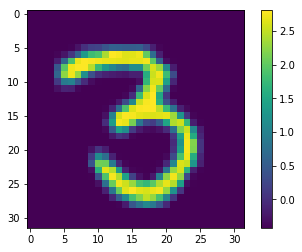

In [5]:
examples = list(test_loader)
print (examples[0][0].shape)
print (examples[0][1].shape)
print (examples[0][0][0].shape)

plt.imshow (examples[0][0][0].view(slen,slen))
plt.colorbar()
plt.show()

In [6]:
results = vae.encoder(examples[0][0][0].view(1,1,slen,slen).cuda())

In [7]:
results[0].shape

torch.Size([64, 8, 8])

In [8]:
name='test'+'_mnist_'+time.strftime("%m-%d-%Y_%H-%M-%S")
print (name)

test_mnist_12-02-2020_03-19-43


In [ ]:
name='test_mnist_'+time.strftime("%m-%d-%Y_%H-%M-%S")
os.makedirs(name, exist_ok=True)
recon_dir = os.path.join (name,'results_recon')
os.makedirs(recon_dir, exist_ok=True)
gen_dir = os.path.join (name,'results_gen')
os.makedirs(gen_dir, exist_ok=True)

lr = 0.0005
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=1e-5)
train_epoch = 50

re_loss_arr = []
kl_loss_arr = []

# for decode testing, batch size of 64
sample1 = torch.randn(64, z_size).view(-1, z_size).cuda()

for epoch in tqdm(range(train_epoch)):
    
    re_loss = 0
    kl_loss = 0
    
    for x in train_loader:
        x = x[0].cuda()
        vae.zero_grad()
#         print (x.shape)
        recon, mu, logvar = vae(x)
#         print (recon.shape)
        loss = vae.loss_function(recon, x, mu, logvar, kld_weight=0.1)
        loss_re, loss_kl = loss['reconstruction_loss'], loss['KLD']
        (loss_re + loss_kl).backward()
        vae_optimizer.step()
        re_loss += loss_re.detach().item()
        kl_loss += loss_kl.detach().item()

    re_loss /= len(train_loader)
    kl_loss /= len(train_loader)
    print('\n[%d/%d] recon loss: %.9f, KL loss: %.9f' % (
        (epoch + 1), train_epoch, re_loss, kl_loss))
    re_loss_arr.append(re_loss)
    kl_loss_arr.append(kl_loss)
    if epoch % 2 == 0:
        with torch.no_grad():
            vae.eval()
            x_rec, _, _ = vae(x)
            resultsample = torch.cat([x, x_rec]) * 0.3081 + 0.1307
            resultsample = resultsample.cpu()
            save_image(resultsample.view(-1, in_channels, slen*2, slen),
                       recon_dir + '/' + str(epoch) + '.png')
            x_rec = vae.decode(sample1)
            resultsample = x_rec * 0.3081 + 0.1307
            resultsample = resultsample.cpu()
            save_image(resultsample.view(-1, in_channels, slen, slen),
                       gen_dir + '/' + str(epoch) + '.png')
        vae.train()
        
    # checkpoint
    torch.save(vae.state_dict(), "VAEmodel.pkl")
    
print("Training finish!... save training results")
torch.save(vae.state_dict(), "VAEmodel.pkl")
        

  2%|▏         | 1/50 [00:15<12:31, 15.34s/it]


[1/50] recon loss: 0.611164370, KL loss: 0.043510444


In [ ]:
sample1.shape